# Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
import sklearn

print('Sklearn ver:', sklearn.__version__)

Sklearn ver: 1.1.3


# Import Dataset

In [3]:
df_raw = pd.read_csv('../dataset/online_shoppers_intention.csv')

## Overview
df_raw.sample(5)

Administrative  Administrative_Duration  Informational  \
3931               5               114.666667              0   
2040               2               220.333333              1   
9264               0                 0.000000              4   
6718               0                 0.000000              0   
9927               0                 0.000000              0   

      Informational_Duration  ProductRelated  ProductRelated_Duration  \
3931                     0.0              14               222.666667   
2040                    70.5              75              3537.991667   
9264                     8.0              66              1514.836310   
6718                     0.0               1                 0.000000   
9927                     0.0               8               181.000000   

      BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
3931     0.080000   0.097778     0.00000         0.8   May                 3   
2040     0.011714   0.027362     5.77096         0.0   Mar                 2   
9264     0.022887   0.044914     0.00000         0.0   Dec                 2   
6718     0.200000   0.200000     0.00000         0.0   Aug                 2   
9927     0.025000   0.070833     0.00000         0.0   Nov                 2   

      Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
3931        2       3           13  Returning_Visitor    False    False  
2040        2       6            1  Returning_Visitor    False    False  
9264        2       6            2  Returning_Visitor    False    False  
6718        5       7            1  Returning_Visitor    False    False  
9927        2       4           13  Returning_Visitor    False    False

# Data Cleansing

In [4]:
### Copy Raw Dataset
df_clean = df_raw.copy()

## Missing Values

In [5]:
df_clean.isnull().sum().sum()

0

Tidak ada missing value yang perlu ditangani

## Duplicated Rows

In [6]:
df_clean.duplicated().sum()

125

Dari hasil tersebut dapat dilihat bahawa ada 125 data yang duplicat dan data tersebut perlu di hapus

In [7]:
### Menghapus baris duplikat
df_clean.drop_duplicates(inplace=True)

## Handle Outliers

In [8]:
### Fitur dengan outlier ekstrim
feat_w_outl = ['Informational', 'ProductRelated', 'ProductRelated_Duration', 
               'PageValues']

### Coba Drop Outlier
df_no_outl = df_clean.copy()

for i in feat_w_outl:
    q1 = df_no_outl[i].quantile(.25)
    q3 = df_no_outl[i].quantile(.75)
    iqr = q3 - q1
    
    df_no_outl = df_no_outl[(df_no_outl[i] >= q1 - 1.5*iqr) & (df_no_outl[i] <= q3 + 1.5*iqr)]

In [9]:
### Cek dimensi
print('Dimensi sebelum remove outlier:', df_clean.shape)
print('Dimensi setelah remove outlier:', df_no_outl.shape)

### Cek balance target
print('Imbalance sebelum remove outlier')
print(df_clean['Revenue'].value_counts(normalize = True))
print('Imbalance setelah remove outlier')
print(df_no_outl['Revenue'].value_counts(normalize = True))

Dimensi sebelum remove outlier: (12205, 18)
Dimensi setelah remove outlier: (7164, 18)
Imbalance sebelum remove outlier
False    0.843671
True     0.156329
Name: Revenue, dtype: float64
Imbalance setelah remove outlier
False    0.97306
True     0.02694
Name: Revenue, dtype: float64


Setelah remove outlier banyak data target 1 (Revenue True) yang hilang. Mengindikasikan kalau outlier tersebut sebenarnya adalah pola yang wajar. Sehingga outlier tidak kami hilangkan.

## Feature Encoding

In [10]:
### Target
df_clean['Revenue'] = df_clean['Revenue'].astype('int')

### Weekend
df_clean['Weekend'] = df_clean['Weekend'].astype('int')

In [11]:
### Feature engineering untuk fitur-fitur yang banyak unique

### Month
df_clean['Month'] = df_clean['Month'].apply(lambda x : x if x in ['Mar', 'May', 'Nov', 'Dec'] else 'Other')

### OperatingSystem
df_clean['OperatingSystems'] = df_clean['OperatingSystems'].apply(lambda x : x if x in [1, 2, 3] else 'Other')

### Browser
df_clean['Browser'] = df_clean['Browser'].apply(lambda x : x if x in [1, 2] else 'Other')

### Region
df_clean['Region'] = df_clean['Region'].apply(lambda x : x if x in [1, 3] else 'Other')

### TrafficType
df_clean['TrafficType'] = df_clean['TrafficType'].apply(lambda x : x if x in [1, 2, 3] else 'Other')

In [12]:
### One Hot Encoding

### Fitur numerik
num_feat = [feature for feature in df_clean.columns if df_clean[feature].dtypes != 'O' and 
              feature not in ['Weekend', 'Revenue']]

### Fitur kategorik
cat_feat = [feature for feature in df_clean.columns if df_clean[feature].dtypes == 'O']

#### OHE
for i in cat_feat:
    df_ohe = pd.get_dummies(df_clean[i], drop_first=True, prefix = i)
    
    df_clean.drop(i, axis = 1, inplace=True)
    df_clean = pd.concat([df_clean, df_ohe], axis = 1)

## Transformation

In [13]:
### Train Test Split
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_clean, test_size=.2, random_state=42)

In [14]:
### Cek apakah ada fitur numerik yang tidak memuat 0
for i in num_feat:
    if 0 not in df_clean[i].unique():
        print(i)
        
### Transformasi Yeo Johnson (karena semua fitur numerik mengandung 0)
from sklearn.preprocessing import PowerTransformer

for i in num_feat:
    
    pt = PowerTransformer()
    pt.fit(df_train[[i]])
    df_train[i] = pt.transform(df_train[[i]])
    df_test[i] = pt.transform(df_test[[i]])

In [15]:
### Scaling
from sklearn.preprocessing import MinMaxScaler

for i in num_feat:
    sc = MinMaxScaler()
    sc.fit(df_train[[i]])
    df_train[i] = sc.transform(df_train[[i]])
    df_test[i] = sc.transform(df_test[[i]])

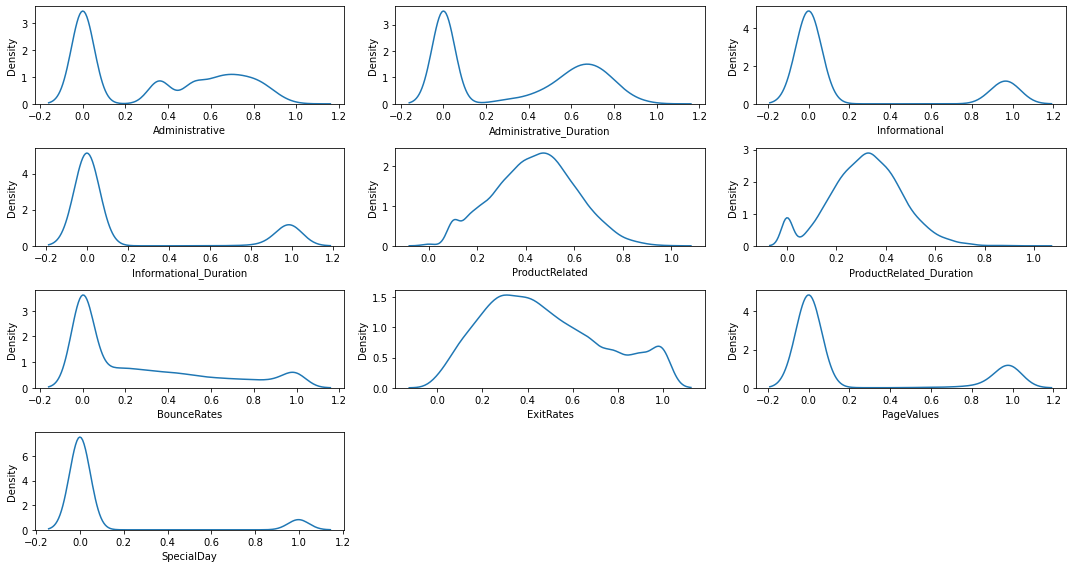

In [16]:
### Cek distribusi setelah transformasi

plt.figure(figsize=(15, 8))
for i in range(0, len(num_feat)):
    plt.subplot(4, 3, i+1)
    sns.kdeplot(df_train[num_feat[i]])
    plt.tight_layout()

Beberapa fitur menjadi lebih normal

## Imbalance

# Feature Engineering

## Feature Selection

## Feature Extraction

## Additional Features